In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
from XSpect.XSpect_Processor import Peaks
from XSpect.XSpect_Processor import Background
from matplotlib.patches import Patch
import pickle


## Viewing Static XES Spectra

Processing: 100%|██████████| 7/7 [00:00<00:00, 12.13Shot_Batch/s]


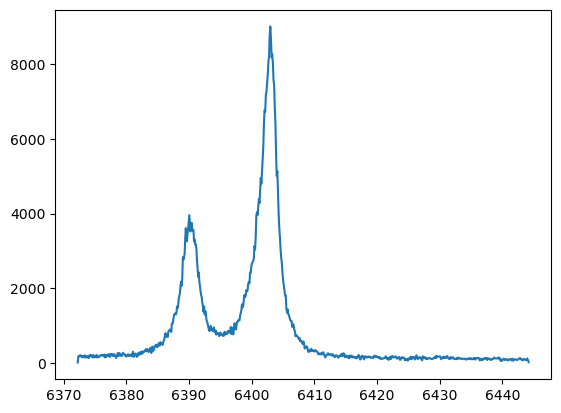

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1033223',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.key_epix=['epix_1/ROI_0_area'] #Uncomment this for additional detector.
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[0,50]]
xes.add_filter('xray','ipm',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=2
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
xes.run_parser(['10']) 
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=41.25, R=250,  mm_per_pixel=0.05, d=0.981)
#v.make_energy_axis(A=67.78, R=250,mm_per_pixel=0.05, d=0.859)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()



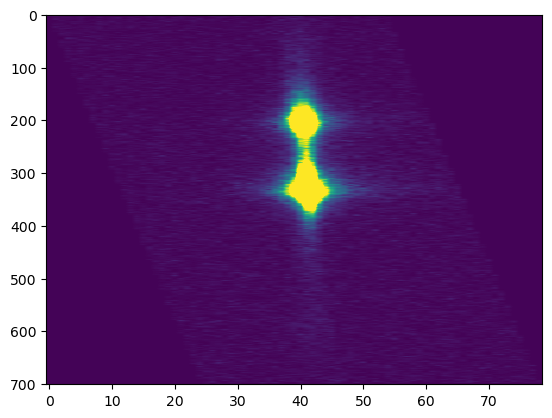

In [3]:
xes.analyzed_runs[0].epix
v.combine_static_spectra(xes_analysis=xes,xes_key='epix')
v.summed_xes.shape
vmin, vmax = np.percentile(v.summed_xes, [1,99])
plt.imshow(v.summed_xes,vmin = vmin, vmax = vmax, aspect='auto')

In [4]:
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.summed_xes.shape

(701,)

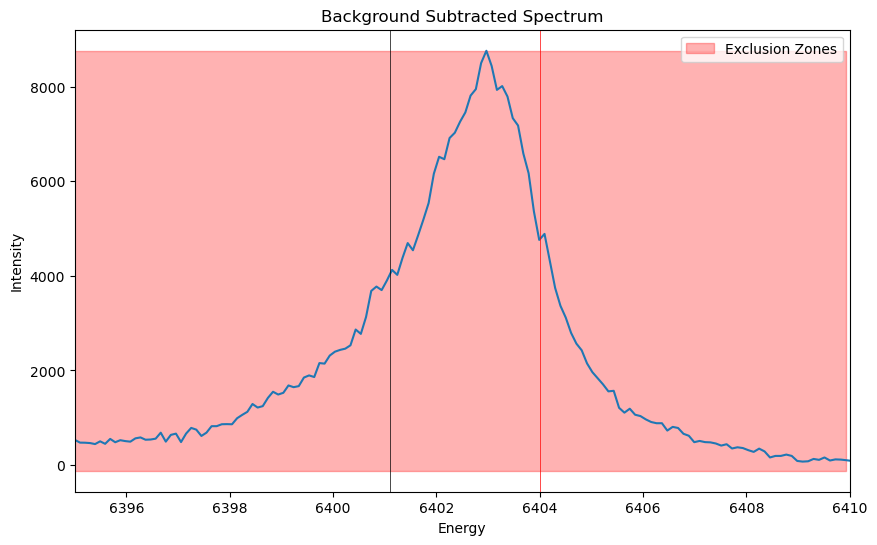

In [9]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,6398,6408)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,6398,6408)
exclusions= (
   # (6360, 6373), #edge of detector
    (6384, 6410),
    # (7457,7485), #Main peaks
    #(7489,7491),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)

 
  
plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.axvline(6404, color = 'r',linewidth=0.5)
plt.axvline(6401.1, color = 'k', linewidth=0.5)
plt.xlim(6395,6410)
plt.show()
xes.first_moment=Peaks.first_moment(v.energy,v.background_subtracted,6398,6408)
xes.popt=Peaks.gaussian_fwhm(v.energy,v.background_subtracted,6401,6405,all_vals=True)
#print(xes.first_moment,xes.fwhm)


(6395.0, 6410.0)

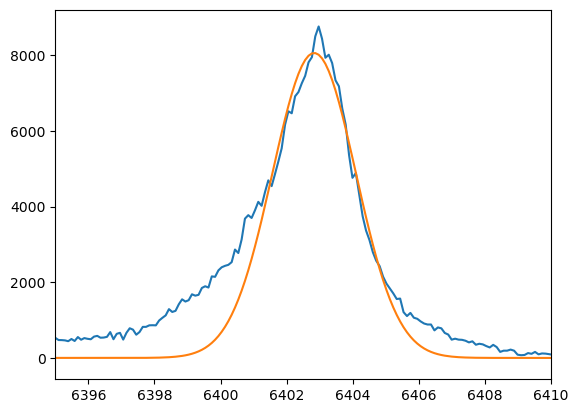

In [10]:
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.plot(v.energy, Peaks.gaussian(v.energy,*xes.popt))
plt.xlim(6395,6410)

6402.534748358297 2.9709347467489335


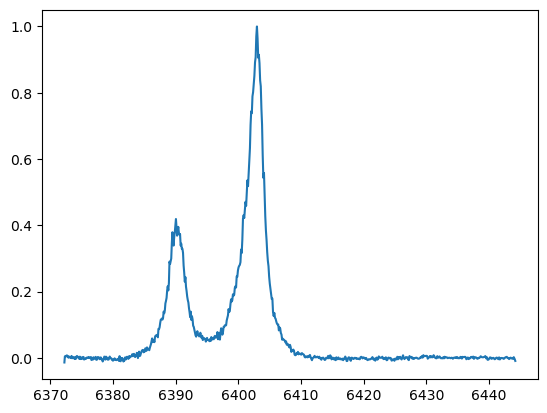

In [11]:
#First moment calculated after maximum peak normalized to 1
v.normalize_peak(6386,6418)
xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,6398,6408)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,6401,6405)
plt.plot(v.energy,v.normalized_peak)

print(xes.first_moment,xes.fwhm)

Text(0, 0.5, 'Normalized Intensity')

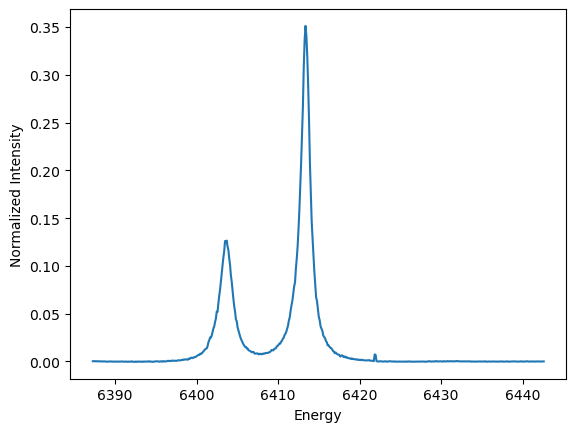

In [92]:
#Normalizes spectrum to make the area under in specified range equal to unity
v.normalize_spectrum(6386,6418)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')


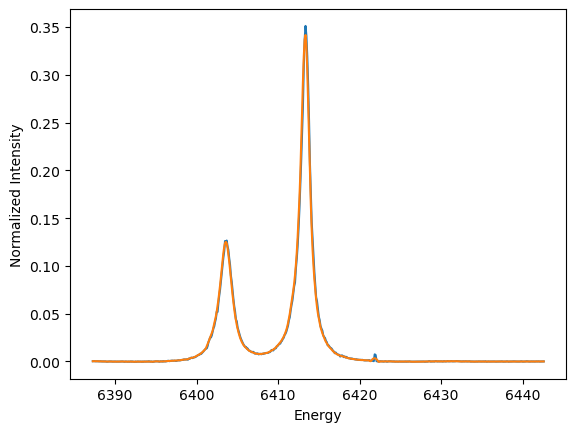

In [93]:
v.smoothed = signal.savgol_filter(v.normalized, window_length=10, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [94]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 6413.198990891865
FWHM: 1.775754937431409
Run Number: 10
  Total: 13223
  X-ray Total: 12329
  Laser Total: 13223
  XES_Hits: 10742
  Percent_XES_Hits: 81.24%



In [15]:
#xes.run_parser(['77-89','91-92']) #Red
#xes.run_parser(['93-99','101-102','105-109']) #2s
#xes.run_parser(['112-114','116-117','121-125','128-132']) #1s
with open(f'data_{str(xes.runs)}.pkl', 'rb') as f:
    data_AlkB_O2_2s = pickle.load(f)
   
with open(f'analysis_{str(xes.runs)}.pkl', 'rb') as f:
    analysis_AlkB_O2_2s = pickle.load(f)

In [8]:
plt.plot(analysis_AlkB_Red.energy,analysis_AlkB_Red.normalized)
plt.plot(analysis_AlkB_O2_1s.energy,analysis_AlkB_O2_1s.normalized)
plt.plot(analysis_AlkB_O2_2s.energy,analysis_AlkB_O2_2s.normalized)



NameError: name 'analysis_AlkB_Red' is not defined

In [21]:
print('Red','1s','2s')
print(data_AlkB_Red.fwhm,data_AlkB_O2_1s.fwhm,data_AlkB_O2_2s.fwhm)
print(data_AlkB_Red.first_moment,data_AlkB_O2_1s.first_moment,data_AlkB_O2_2s.first_moment)

Red 1s 2s
4.755108014923971 4.572660191093797 4.6242412679605005
6408.181150255361 6408.0481155164 6408.117108026208


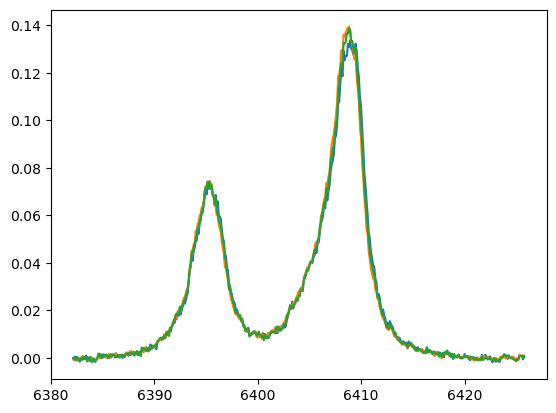

In [43]:
plt.plot(analysis_AlkB_Red.energy[70:500],analysis_AlkB_Red.normalized[70:500])
plt.plot(analysis_AlkB_O2_1s.energy[70:500],analysis_AlkB_O2_1s.normalized[70:500])
plt.plot(analysis_AlkB_O2_2s.energy[70:500],analysis_AlkB_O2_2s.normalized[70:500])

In [ ]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[95,110]]
xes.add_filter('xray','ipm',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
xes.run_parser(['230'])
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=43.25, R=250,  mm_per_pixel=0.05, d=0.895)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()

In [ ]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,7030,7072)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,7030,7072)
exclusions= (
    (6980, 6990), #edge of detector
    (7030,7070), #Main peaks
    (7076,7081),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()
with open(f'data_kb__{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_kb_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
v.normalize_spectrum(7030,7070)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()